### Utility functions to extract features and Load Data

In [33]:
import soundfile
import numpy as np
import librosa
import glob
import os
from sklearn.model_selection import train_test_split

# all emotions on RAVDESS dataset
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# we allow only these emotions
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}
    
def extract_feature(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        result = np.array([])
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
        return result
def load_data(test_size=0.2):
    X, y = [], []
    for file in glob.glob("data/Actor_*/*.wav"):
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # extract speech features
        features = extract_feature(file)
        # add to data
        X.append(features)
        y.append(emotion)
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

### Loading data and fit into our MLP Classifier

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import os
import pickle
X_train, X_test, y_train, y_test = load_data(test_size=0.25)
print("[+] Number of training samples:", X_train.shape[0])
print("[+] Number of testing samples:", X_test.shape[0])
print("[+] Number of features:", X_train.shape[1])
# best model, determined by a grid search
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500,
}
# initialize Multi Layer Perceptron classifier
# with best parameters ( so far )
model = MLPClassifier(**model_params)

# train the model
print("[*] Training the model...")
model.fit(X_train, y_train)

# predict 25% of data to measure how good we are
y_pred = model.predict(X_test)
# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

# now we save the model
# make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(model, open("result/mlp_classifier.model", "wb"))

[+] Number of training samples: 504
[+] Number of testing samples: 168
[+] Number of features: 40
[*] Training the model...
Accuracy: 80.36%


### Predict Uiltity function

In [35]:
def predict(filename):
    # load the saved model (after training)
    model = pickle.load(open("result/mlp_classifier.model", "rb"))
    features = extract_feature(filename).reshape(1, -1)
    result = model.predict(features)[0]
    print("result:", result)

### Confusion Matrix
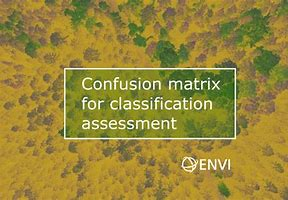

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
cnf_mat=confusion_matrix(y_test,y_pred)
print(cnf_mat)

[[52  4  3  2]
 [ 1 33  4  3]
 [ 1  1 16  3]
 [ 1  4  6 34]]


In [36]:
predict("data/Actor_11/03-01-02-01-02-01-11.wav")

result: sad


In [37]:
predict("data/Actor_02/03-01-03-01-02-01-02.wav")

result: happy
